/var/folders/70/l8z4t_nn5zg7qcq462k9j1m00000gn/T/ipykernel_27526/3911033757.py:12: DtypeWarning: Columns (2,3,6,7,8,9,10,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/zhangyuchuan/Downloads/allgenre_combined_df.csv')


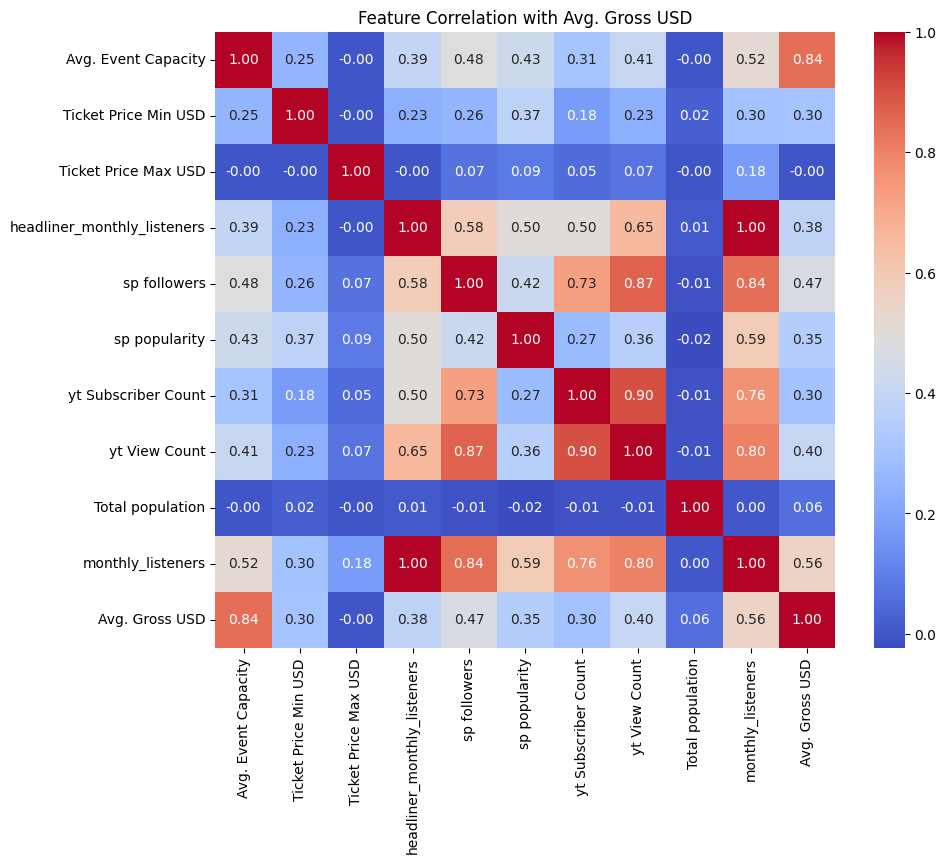

Highly correlated features: ['Avg. Event Capacity', 'Ticket Price Min USD', 'Ticket Price Max USD', 'headliner_monthly_listeners', 'sp followers', 'sp popularity', 'yt Subscriber Count', 'yt View Count', 'Total population', 'monthly_listeners']
Ridge Regression with Polynomial Features Cross-validation Mean RMSE: 11938325190.479918


/Users/zhangyuchuan/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.46654e-34): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/zhangyuchuan/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=2.56375e-34): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/zhangyuchuan/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.84065e-34): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/zhangyuchuan/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.67598e-34): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=

Ridge Regression with Polynomial Features Cross-validation Mean R²: -1454680167.6097412
Ridge Regression with Polynomial Features Test RMSE: 240772.14
Ridge Regression with Polynomial Features Test R²: 0.867


/Users/zhangyuchuan/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.84065e-34): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/zhangyuchuan/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.67598e-34): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/zhangyuchuan/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.81725e-34): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/zhangyuchuan/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=2.01257e-34): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=

In [9]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('/Users/zhangyuchuan/Downloads/allgenre_combined_df.csv')
filtered_data = df[
    (df['Year'] >= 2020) &
    (~(df['Headliner'].str.contains('"', na=False))) &
    (df['Genre'] != 'Family Entertainment') &
    (df['Ticket Price Min USD'] > 0) &
    (df['Ticket Price Min USD'] < df['Ticket Price Max USD'])
]
filtered_data_no_na = filtered_data.dropna()
_, test_data = train_test_split(filtered_data_no_na, test_size=0.3, random_state=42)
train_data = filtered_data.loc[~filtered_data.index.isin(test_data.index)]

# Feature correlation analysis
correlation_matrix = train_data[feature_columns + ['Avg. Gross USD']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation with Avg. Gross USD")
plt.show()

# Select highly correlated features (I chose all features actually :()
high_corr_features = correlation_matrix['Avg. Gross USD'][abs(correlation_matrix['Avg. Gross USD']) > 0].index.tolist()
high_corr_features.remove('Avg. Gross USD')
print("Highly correlated features:", high_corr_features)

# Update train and test sets with selected features
X_train = train_data[high_corr_features]
X_test = test_data[high_corr_features]

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=high_corr_features)
X_test = pd.DataFrame(imputer.transform(X_test), columns=high_corr_features)

# Feature expansion with polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Initialize Ridge Regressor
ridge_model = Ridge(alpha=1.0, random_state=42)

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation for RMSE
cv_rmse_scores_ridge = cross_val_score(
    ridge_model, X_train_poly, y_train, cv=kf, scoring='neg_root_mean_squared_error'
)
mean_cv_rmse_ridge = -np.mean(cv_rmse_scores_ridge)
print("Ridge Regression with Polynomial Features Cross-validation Mean RMSE:", mean_cv_rmse_ridge)

# Perform cross-validation for R²
cv_r2_scores_ridge = cross_val_score(ridge_model, X_train_poly, y_train, cv=kf, scoring='r2')
mean_cv_r2_ridge = np.mean(cv_r2_scores_ridge)
print("Ridge Regression with Polynomial Features Cross-validation Mean R²:", mean_cv_r2_ridge)

# Fit the model on training data
ridge_model.fit(X_train_poly, y_train)

# Predict on testing data
y_pred_ridge_poly = ridge_model.predict(X_test_poly)

# Calculate performance metrics
rmse_ridge_poly = mean_squared_error(y_test, y_pred_ridge_poly, squared=False)
r2_ridge_poly = r2_score(y_test, y_pred_ridge_poly)
print(f"Ridge Regression with Polynomial Features Test RMSE: {rmse_ridge_poly:.2f}")
print(f"Ridge Regression with Polynomial Features Test R²: {r2_ridge_poly:.3f}")
